# Analysis: Arrests By Time-Periods

Workflow: 3 <br>
Goal: Run analysis on arrest / population ratio for periods of time. <br>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

import crime_helper as ch

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', -1)

## Initial Setup

In [3]:
ARREST_FILE = 'data/arrest_tkm_state.csv'
EMPLOYMENT_FILE = 'data/employment_state.csv'
OFFENDER_FILE = 'data/offender_tkm_state.csv'
OFFENSE_FILE = 'data/offense_tkm_state.csv'
VICTIM_FILE = 'data/victim_tkm_state.csv'
STATE_FILE = 'data/lookup_state.csv'
REGION_FILE = 'data/lookup_region.csv'

In [4]:
state_df = pd.read_csv(STATE_FILE)
state_df.head()
state_df.info()

,region_code,state_abbr,state_fips_code,state_id,state_name
0,4,AK,2.0,1,Alaska
1,3,AL,1.0,2,Alabama
2,3,AR,5.0,3,Arkansas
3,99,AS,60.0,4,American Samoa
4,4,AZ,4.0,5,Arizona


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 5 columns):
region_code        58 non-null int64
state_abbr         58 non-null object
state_fips_code    57 non-null float64
state_id           58 non-null int64
state_name         58 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 2.3+ KB


In [5]:
region_df = pd.read_csv(REGION_FILE)
region_df

,region_code,region_desc,region_name
0,0,U.S. Territories,U.S. Territories
1,1,Region I,Northeast
2,2,Region II,Midwest
3,3,Region III,South
4,4,Region IV,West
5,99,Other,Other


In [6]:
state_full_df = pd.merge(state_df, region_df, how='inner', on='region_code')
state_full_df.head()

,region_code,state_abbr,state_fips_code,state_id,state_name,region_desc,region_name
0,4,AK,2.0,1,Alaska,Region IV,West
1,4,AZ,4.0,5,Arizona,Region IV,West
2,4,CA,6.0,6,California,Region IV,West
3,4,CO,8.0,7,Colorado,Region IV,West
4,4,HI,15.0,15,Hawaii,Region IV,West


In [7]:
state_clean_df = state_full_df.sort_values('state_abbr').reset_index()
state_clean_df = state_clean_df[['state_abbr', 'state_name', 'region_code', 'region_name']]
state_clean_df.head(10)
state_clean_df.info()

,state_abbr,state_name,region_code,region_name
0,AK,Alaska,4,West
1,AL,Alabama,3,South
2,AR,Arkansas,3,South
3,AS,American Samoa,99,Other
4,AZ,Arizona,4,West
5,CA,California,4,West
6,CO,Colorado,4,West
7,CT,Connecticut,1,Northeast
8,CZ,Canal Zone,99,Other
9,DC,District of Columbia,3,South


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
state_abbr     58 non-null object
state_name     58 non-null object
region_code    58 non-null int64
region_name    58 non-null object
dtypes: int64(1), object(3)
memory usage: 1.9+ KB


In [154]:
# create list of states in region for presentation 

region_ls = []

for rgc in [1,2,3,4]:
    region_name = region_df.loc[region_df['region_code']==rgc]['region_name'].iloc[0]
    #print(region_name)

    states_sr = state_clean_df.loc[state_clean_df['region_code']==rgc]['state_abbr']
    #print(states_sr)
    states_st = ''
    
    for idx, stb in states_sr.items():
        states_st += stb + ', '
                
    new_dx = {
        'Region': region_name,
        'States': states_st[:-2],
    }
    region_ls.append(new_dx)

region_pres_df = pd.DataFrame(region_ls)
region_pres_df.style.set_properties(subset=['States'], **{'width': '170px'})
region_pres_df

,Region,States
0,Northeast,"CT, MA, ME, NH, NJ, NY, PA, PR, RI, VT"
1,Midwest,"IA, IL, IN, KS, MI, MN, MO, ND, NE, OH, SD, WI"
2,South,"AL, AR, DC, DE, FL, GA, KY, LA, MD, MS, NC, OK, SC, TN, TX, VA, WV"
3,West,"AK, AZ, CA, CO, HI, ID, MT, NM, NV, OR, UT, WA, WY"


,Region,States
0,Northeast,"CT, MA, ME, NH, NJ, NY, PA, PR, RI, VT"
1,Midwest,"IA, IL, IN, KS, MI, MN, MO, ND, NE, OH, SD, WI"
2,South,"AL, AR, DC, DE, FL, GA, KY, LA, MD, MS, NC, OK, SC, TN, TX, VA, WV"
3,West,"AK, AZ, CA, CO, HI, ID, MT, NM, NV, OR, UT, WA, WY"


## Explore Arrests

In [8]:
arrest_df = pd.read_csv(ARREST_FILE)
arrest_df = arrest_df.rename(columns={'count': 'arrests'})
arrest_df.head()
arrest_df.info()

,state,year,gender,offense,arrests
0,AK,2000,female,aggravated-assault,194
1,AK,2000,female,arson,3
2,AK,2000,female,burglary,49
3,AK,2000,female,curfew,1
4,AK,2000,female,disorderly-conduct,221


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51102 entries, 0 to 51101
Data columns (total 5 columns):
state      51102 non-null object
year       51102 non-null int64
gender     51102 non-null object
offense    51102 non-null object
arrests    51102 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.9+ MB


In [9]:
arrest_total_df = arrest_df.groupby(['state', 'year']).sum().sort_values(['state', 'year'])
arrest_total_df = arrest_total_df.reset_index()
arrest_total_df.head()
arrest_total_df.info()

,state,year,arrests
0,AK,2000,21354
1,AK,2001,20267
2,AK,2002,19818
3,AK,2003,22746
4,AK,2004,21027


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 3 columns):
state      952 non-null object
year       952 non-null int64
arrests    952 non-null int64
dtypes: int64(2), object(1)
memory usage: 22.4+ KB


In [10]:
arrest_total_df.loc[arrest_total_df['state']=='AL']

,state,year,arrests
19,AL,2000,105172
20,AL,2001,112383
21,AL,2002,123707
22,AL,2003,128910
23,AL,2004,129373
24,AL,2005,110115
25,AL,2006,99804
26,AL,2007,122305
27,AL,2008,130248
28,AL,2009,118120


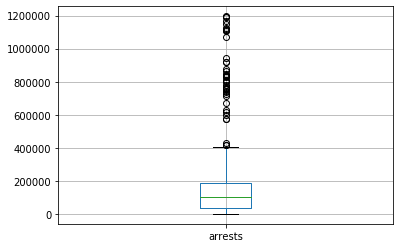

In [11]:
arrest_total_df.boxplot(column=['arrests'])

In [12]:
arrest_year_df = arrest_total_df.groupby(['year']).count().sort_values(['year']) 
arrest_year_df = arrest_year_df.rename(columns={'arrests': 'row_count'})
arrest_year_df

,state,row_count
year,,
2000,48,48
2001,50,50
2002,50,50
2003,50,50
2004,50,50
2005,50,50
2006,50,50
2007,50,50
2008,50,50


## Explore Employment

In [13]:
employment_df = pd.read_csv(EMPLOYMENT_FILE)
employment_df.head()
employment_df.info()

,agency_ct,civilian_ct,year,female_civilian_ct,female_officer_ct,female_total_ct,male_civilian_ct,male_officer_ct,male_total_ct,pe_ct_per_1000,population,state_abbr,state_name,total_pe_ct
0,32,675.0,2000,475.0,103.0,578.0,200.0,1055.0,1255.0,2.92,626932,AK,Alaska,1833.0
1,33,661.0,2001,463.0,107.0,570.0,198.0,1097.0,1295.0,2.94,634892,AK,Alaska,1865.0
2,33,701.0,2002,482.0,112.0,594.0,219.0,1091.0,1310.0,2.96,643893,AK,Alaska,1904.0
3,33,682.0,2003,470.0,111.0,581.0,212.0,1063.0,1275.0,2.86,648921,AK,Alaska,1856.0
4,34,688.0,2004,470.0,127.0,597.0,218.0,1125.0,1343.0,2.96,655932,AK,Alaska,1940.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 14 columns):
agency_ct             969 non-null int64
civilian_ct           969 non-null float64
year                  969 non-null int64
female_civilian_ct    969 non-null float64
female_officer_ct     969 non-null float64
female_total_ct       969 non-null float64
male_civilian_ct      969 non-null float64
male_officer_ct       969 non-null float64
male_total_ct         969 non-null float64
pe_ct_per_1000        969 non-null float64
population            969 non-null int64
state_abbr            969 non-null object
state_name            969 non-null object
total_pe_ct           969 non-null float64
dtypes: float64(9), int64(3), object(2)
memory usage: 106.1+ KB


In [14]:
population_df = employment_df[['state_abbr', 'year', 'population']]
population_df.head()

,state_abbr,year,population
0,AK,2000,626932
1,AK,2001,634892
2,AK,2002,643893
3,AK,2003,648921
4,AK,2004,655932


In [15]:
population_df.groupby('year').count()

,state_abbr,population
year,,
2000,51,51
2001,51,51
2002,51,51
2003,51,51
2004,51,51
2005,51,51
2006,51,51
2007,51,51
2008,51,51


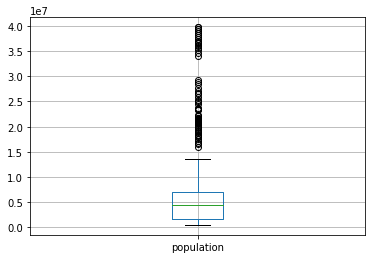

In [16]:
population_df.boxplot(column='population')

## Merge DataFrames

In [17]:
merge_1_df = pd.merge(arrest_total_df, population_df, how='inner', 
                      left_on=['state', 'year'], right_on=['state_abbr', 'year'])
merge_1_df.head()
merge_1_df.shape

,state,year,arrests,state_abbr,population
0,AK,2000,21354,AK,626932
1,AK,2001,20267,AK,634892
2,AK,2002,19818,AK,643893
3,AK,2003,22746,AK,648921
4,AK,2004,21027,AK,655932


(949, 5)

In [18]:
merge_2_df = pd.merge(merge_1_df, state_clean_df, how='inner', left_on=['state'], right_on=['state_abbr'])
merge_2_df.head()

,state,year,arrests,state_abbr_x,population,state_abbr_y,state_name,region_code,region_name
0,AK,2000,21354,AK,626932,AK,Alaska,4,West
1,AK,2001,20267,AK,634892,AK,Alaska,4,West
2,AK,2002,19818,AK,643893,AK,Alaska,4,West
3,AK,2003,22746,AK,648921,AK,Alaska,4,West
4,AK,2004,21027,AK,655932,AK,Alaska,4,West


In [19]:
merge_df = merge_2_df[['region_name', 'state', 'year', 'arrests', 'population']]
merge_df.head()
merge_df.shape

,region_name,state,year,arrests,population
0,West,AK,2000,21354,626932
1,West,AK,2001,20267,634892
2,West,AK,2002,19818,643893
3,West,AK,2003,22746,648921
4,West,AK,2004,21027,655932


(949, 5)

## Analyze & Clean

In [20]:
merge_df['arrest_popu'] = round(merge_df['arrests'] / merge_df['population'], 6)
merge_df.head()
merge_df.info()

/Users/philbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,region_name,state,year,arrests,population,arrest_popu
0,West,AK,2000,21354,626932,0.034061
1,West,AK,2001,20267,634892,0.031922
2,West,AK,2002,19818,643893,0.030778
3,West,AK,2003,22746,648921,0.035052
4,West,AK,2004,21027,655932,0.032057


<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 0 to 948
Data columns (total 6 columns):
region_name    949 non-null object
state          949 non-null object
year           949 non-null int64
arrests        949 non-null int64
population     949 non-null int64
arrest_popu    949 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 51.9+ KB


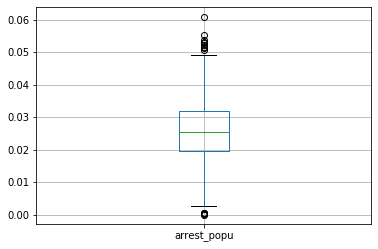

In [21]:
merge_df.boxplot(column=['arrest_popu'])

In [22]:
merge_df.sort_values(['arrest_popu']).head(20)
merge_df.sort_values(['arrest_popu']).tail(20)

,region_name,state,year,arrests,population,arrest_popu
170,South,FL,2017,754,21152963,0.000036
479,West,MT,2004,71,1543792,0.000046
31,South,AL,2012,1597,4834334,0.000330
30,South,AL,2011,1676,4815348,0.000348
32,South,AL,2013,1807,4845981,0.000373
33,South,AL,2014,2480,4861676,0.000510
146,South,DC,2014,1766,658893,0.002680
144,South,DC,2012,1739,632323,0.002750
147,South,DC,2015,1882,672228,0.002800
145,South,DC,2013,1951,646449,0.003018


,region_name,state,year,arrests,population,arrest_popu
932,West,WY,2002,22427,504213,0.044479
741,South,SC,2000,183470,4075438,0.045018
934,West,WY,2004,23367,512254,0.045616
901,Midwest,WI,2009,265352,5792996,0.045806
608,West,NV,2000,91847,2003421,0.045845
776,Midwest,SD,2016,42631,915036,0.046589
935,West,WY,2005,24426,515094,0.047420
930,West,WY,2000,24050,499238,0.048173
931,West,WY,2001,24150,499886,0.048311
936,West,WY,2006,25189,521073,0.048341


In [23]:
# throw out anomalous data

merge_filter_df = merge_df.loc[merge_df['arrest_popu'].between(0.004, 0.05)]
merge_filter_df.shape

(923, 6)

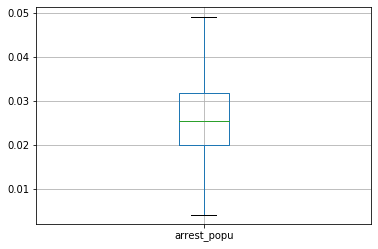

In [24]:
merge_filter_df.boxplot(column=['arrest_popu'])

In [25]:
# not much data was cut out 

merge_filter_df.groupby(['year']).count()[['state']]

,state
year,
2000,47
2001,49
2002,48
2003,49
2004,49
2005,49
2006,49
2007,48
2008,48


## Create Region Series

In [26]:
# midwest

region_MW_df = merge_filter_df.loc[merge_filter_df['region_name']=='Midwest']
region_MW_df.head()

,region_name,state,year,arrests,population,arrest_popu
209,Midwest,IA,2000,86891,3153624,0.027553
210,Midwest,IA,2001,74117,3199087,0.023168
211,Midwest,IA,2002,87312,3146200,0.027752
212,Midwest,IA,2003,87885,3193360,0.027521
213,Midwest,IA,2004,86714,3147746,0.027548


In [27]:
region_MW_sr = region_MW_df['arrest_popu']
region_MW_sr.shape

(220,)

In [28]:
# northeast

region_NE_df = merge_filter_df.loc[merge_filter_df['region_name']=='Northeast']
region_NE_df.head()

,region_name,state,year,arrests,population,arrest_popu
114,Northeast,CT,2000,101452,4283356,0.023685
115,Northeast,CT,2001,127143,4178846,0.030425
116,Northeast,CT,2002,100998,4211952,0.023979
117,Northeast,CT,2003,91487,3880135,0.023578
118,Northeast,CT,2004,101612,3792938,0.026790


In [29]:
region_NE_sr = region_NE_df['arrest_popu']
region_NE_sr.shape

(171,)

In [30]:
# west

region_WT_df = merge_filter_df.loc[merge_filter_df['region_name']=='West']
region_WT_df.head()

,region_name,state,year,arrests,population,arrest_popu
0,West,AK,2000,21354,626932,0.034061
1,West,AK,2001,20267,634892,0.031922
2,West,AK,2002,19818,643893,0.030778
3,West,AK,2003,22746,648921,0.035052
4,West,AK,2004,21027,655932,0.032057


In [31]:
region_WT_sr = region_WT_df['arrest_popu']
region_WT_sr.shape

(244,)

In [32]:
# south 

region_ST_df = merge_filter_df.loc[merge_filter_df['region_name']=='South']
region_ST_df.head()

,region_name,state,year,arrests,population,arrest_popu
19,South,AL,2000,105172,4488050,0.023434
20,South,AL,2001,112383,4502059,0.024963
21,South,AL,2002,123707,4516995,0.027387
22,South,AL,2003,128910,4531274,0.028449
23,South,AL,2004,129373,4550680,0.028429


In [33]:
region_ST_sr = region_ST_df['arrest_popu']
region_ST_sr.shape

(288,)

## Check the Region Distributions 

In [34]:
# test for normal distribution of the samples
# extras / sampling distributions .ipynb

k, p = stats.normaltest(region_MW_sr)
p_MW = round(p, 4)

k, p = stats.normaltest(region_NE_sr)
p_NE = round(p, 4)

k, p = stats.normaltest(region_WT_sr)
p_WT = round(p, 4)

k, p = stats.normaltest(region_ST_sr)
p_ST = round(p, 4)

print(f'midwest: {p_MW}')
print(f'northeast: {p_NE}')
print(f'west: {p_WT}')
print(f'south: {p_ST}')

midwest: 0.001
northeast: 0.0001
west: 0.4885
south: 0.0352


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Arrests/Population'),
 Text(0.5, 1.0, 'Midwest')]

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Arrests/Population'),
 Text(0.5, 1.0, 'Northeast')]

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Arrests/Population'),
 Text(0.5, 1.0, 'West')]

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Arrests/Population'),
 Text(0.5, 1.0, 'South')]

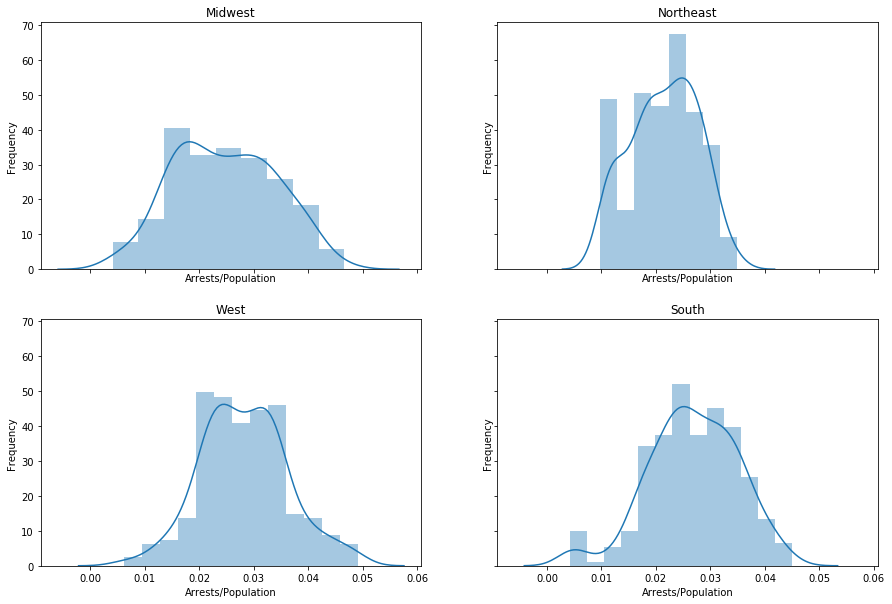

In [53]:
# plot the distributions

fig, axs = plt.subplots(2,2, figsize=(15, 10), sharey=True, sharex=True)

sns.distplot(region_MW_sr, ax=axs[0][0])
axs[0][0].set(xlabel='Arrests/Population', ylabel='Frequency', title='Midwest')
#ax1.set_xticklabels(labels=df_genre_cnt_plot.index, rotation=90)

sns.distplot(region_NE_sr, ax=axs[0][1])
axs[0][1].set(xlabel='Arrests/Population', ylabel='Frequency', title='Northeast')

sns.distplot(region_WT_sr, ax=axs[1][0])
axs[1][0].set(xlabel='Arrests/Population', ylabel='Frequency', title='West')

sns.distplot(region_ST_sr, ax=axs[1][1])
axs[1][1].set(xlabel='Arrests/Population', ylabel='Frequency', title='South')

plt.show()

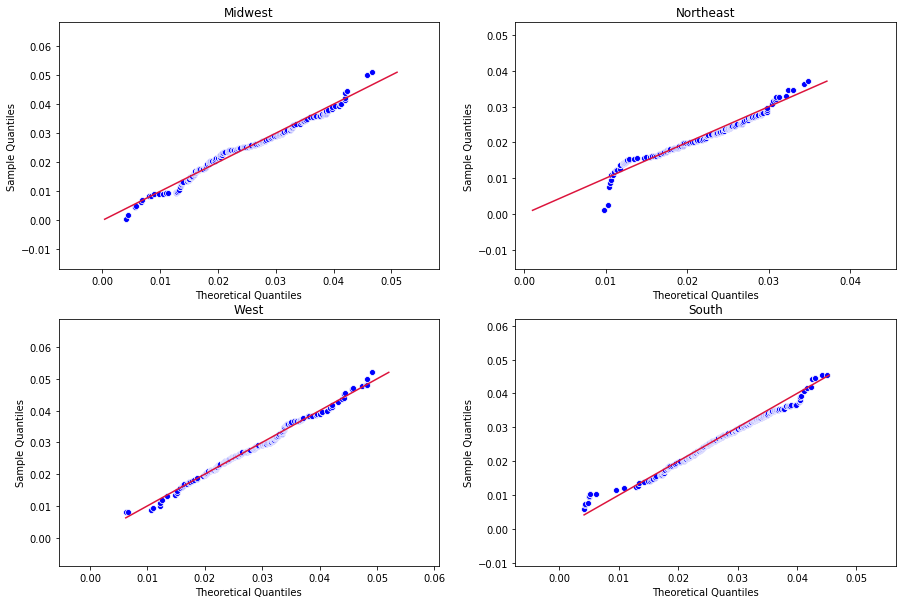

In [121]:
def seaborn_qqplot(data_ls, axis, title):
    
    # create theoretical uantile dataframe and plot it
    
    normal_ls = np.random.normal(data_ls.mean(), data_ls.std(), data_ls.shape[0])
    percs = np.linspace(0, 100, data_ls.shape[0])
    
    quantile_normal = np.percentile(normal_ls, percs)
    quantile_data = np.percentile(data_ls, percs)
    plot_df = pd.DataFrame({'y': quantile_normal, 'x': quantile_data})
    
    sns.scatterplot(y='y', x='x', data=plot_df, ax=axis, color='blue')
    
    # plot fit line
    
    line_ls = np.linspace(np.min((quantile_normal.min(),quantile_data.min())), 
                          np.max((quantile_normal.max(),quantile_data.max())))
    line_df = pd.DataFrame({'y': line_ls, 'x': line_ls})
    
    sns.lineplot(y='y', x='x', data=line_df, ax=axis, color='crimson', dashes=True)
    
    #sns.distplot(normal_ls, color='red', ax=axis)
    #sns.distplot(data_ls, color='blue', ax=axis)
    
    axis.set(ylabel='Sample Quantiles', xlabel='Theoretical Quantiles', title=title)
    
    
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

seaborn_qqplot(region_MW_sr, axs[0][0], 'Midwest')
seaborn_qqplot(region_NE_sr, axs[0][1], 'Northeast')
seaborn_qqplot(region_WT_sr, axs[1][0], 'West')
seaborn_qqplot(region_ST_sr, axs[1][1], 'South')

In [35]:
# run anova 
# week 2 / day 3 / anova.ipynb



In [36]:
# tukey test, 2-sample t-tests (for each pair)
# stats.t.indep


In [37]:
region_1_sr = region_1_df['']

NameError: name 'region_1_df' is not defined

In [ ]:
save_path = r'data/crime_data_full.csv'
merge_df.to_csv(save_path, index=False)
f'{round(os.path.getsize(save_path) /1e6, 2)} mb'